## Exercise SEP Developer Test

This test is designed to assess your ability to design and develop a project from a limited set of goals, provided below. We will evaluate your project based on its fulfillment of the outlined objectives, code efficiency, readability, and adherence to best practices. Additionally, we will evaluate the structure and content of your GitHub repository according to standard practices.

1. Please perform all coding within the Google Colab environment: http://colab.research.google.com
    * Please store your project in a GitHub repository, so we can fork and run it in Colab.
        * Additionally, please create a standard GitHub repository with the expected files and directory structure.    
    * Please note that Colab doesn't automatically include additional files. To avoid potential issues, we recommend only including files that the evaluators already have access to.    
    * The evaluators will use the files SEP01.mseed, SEP02.mseed, and SEP03.mseed, which can be found in this GitHub project.
2. Import the mseed files
3. Create a database with proper normal form and constraints
4. Import the data into the newly created database
5. Create a visualization for the data. The visualization can be static but must include:    
    * A title
    * Text section displaying metadata about the miniseed data
    * Helicorder-style charts of the miniseed data (These may be built from the database data or the mseed files)
    * A map with icons indicating station locations based on the miniseed data (station lat and lon can be found on iris' API)
    * Add to the map additional stations found on IRIS' data API. Stations of interest include HOA and SUG
        * Data API information can be found at http://service.iris.edu/fdsnws/station/1/



In [7]:
# Start Here
import warnings
warnings.filterwarnings('ignore')

# Pre-work -- creating a database, importing data

## First path: Creating a SQLite database

Here, we'll just do the relatively straightforward work of:

* Creating a sqlite database with the proper schema, associated with `.mseed` files
* Using `obspy` to process each trace in the streams, inserting them one by one.

In [8]:
from src.create_db import create_database, process_mseed_files

In [9]:
create_database()

In [10]:
process_mseed_files()

Processed SEP/SEP03.mseed
Processed SEP/SEP01.mseed
Processed SEP/SEP02.mseed


And done! Here are a few simple operations on our newly created `seismic_data.db` database file.

In [11]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('seismic_data.sqlite')

# Get info about traces table
traces_df = pd.read_sql_query("""
    SELECT 
        network,
        station,
        channel,
        starttime,
        endtime,
        sampling_rate,
        npts
    FROM traces 
    LIMIT 5
""", conn)

In [12]:
print("Number of traces:", pd.read_sql_query("SELECT COUNT(*) as count FROM traces", conn)['count'][0])
print("\nSample of traces:")
display(traces_df)

Number of traces: 32

Sample of traces:


,network,station,channel,starttime,endtime,sampling_rate,npts
0,CC,SEP,EHZ,2023-11-25T00:00:00.000001Z,2023-11-25T07:54:21.590001Z,100.0,2846160
1,CC,SEP,EHZ,2023-11-25T07:55:19.600001Z,2023-11-25T08:31:21.590001Z,100.0,216200
2,CC,SEP,EHZ,2023-11-25T08:33:04.600001Z,2023-11-25T15:51:13.590001Z,100.0,2628900
3,CC,SEP,EHZ,2023-11-25T15:52:05.600001Z,2023-11-25T16:11:04.590001Z,100.0,113900
4,CC,SEP,EHZ,2023-11-25T16:11:07.600001Z,2023-11-25T16:32:54.590001Z,100.0,130700


In [13]:
print("\nUnique stations:")
display(pd.read_sql_query("SELECT DISTINCT station FROM traces", conn))


Unique stations:


,station
0,SEP


## Alternate path -- Using `mseedindex` (WARNING! These steps might not work on Colab! I just included this blurb as an alternate path!)

Following the guidance of NSF Sage in [this newsletter article](https://ds.iris.edu/ds/newsletter/vol24/no1/547/efficiently-reading-large-miniseed-data-sets-using-obspy/), the best step when it comes to database indexing of multiple `.mseed` files is to utilize `mseedindex` to create a time series index and catalog the data. Of course, there isn't a really huge amount of data in this particular exercise, but it can be really easy for the size of the data to grow to such an extent that reading everything from a database could become inefficient.

In this path, the steps would be to install `mseedindex` and utilize the `tsindex` module from `obspy`.

In [14]:
from src.create_db import create_indexer_db

In [15]:
create_indexer_db()

Leap seconds file `/Users/gabrielruiz/SeismicData/leap-seconds.list` not found.
No leap second file found, none will be used
mseedindex version: 3.0.5


In [16]:
from src.util import get_all_metadata, get_waveforms_for_event

In [17]:
sep01_metadata = get_all_metadata('SEP/SEP01.mseed')
sep02_metadata = get_all_metadata('SEP/SEP02.mseed')
sep03_metadata = get_all_metadata('SEP/SEP03.mseed')

As we can see here, we're able to extract all the metadata and stream / trace data, which would be really helpful with an even larger amount of `.mseed` files.

In [18]:
print(sep01_metadata)

('CC', 'SEP', '--', 'EHZ', UTCDateTime(2023, 11, 11, 0, 0, 0, 1), UTCDateTime(2023, 11, 12, 0, 0, 0, 1))


In [19]:
sep01_waveforms = get_waveforms_for_event(*sep01_metadata)
sep02_waveforms = get_waveforms_for_event(*sep02_metadata)
sep03_waveforms = get_waveforms_for_event(*sep03_metadata)

In [20]:
sep01_waveforms

15 Trace(s) in Stream:
CC.SEP.--.EHZ | 2023-11-11T00:00:00.000001Z - 2023-11-11T00:36:58.090001Z | 100.0 Hz, 221810 samples
CC.SEP.--.EHZ | 2023-11-11T00:37:45.100001Z - 2023-11-11T01:41:06.090001Z | 100.0 Hz, 380100 samples
CC.SEP.--.EHZ | 2023-11-11T01:43:07.100001Z - 2023-11-11T02:01:05.090001Z | 100.0 Hz, 107800 samples
CC.SEP.--.EHZ | 2023-11-11T02:01:47.100001Z - 2023-11-11T02:02:10.090001Z | 100.0 Hz, 2300 samples
CC.SEP.--.EHZ | 2023-11-11T02:02:24.100001Z - 2023-11-11T02:17:01.090001Z | 100.0 Hz, 87700 samples
CC.SEP.--.EHZ | 2023-11-11T02:17:49.100001Z - 2023-11-11T02:31:16.090001Z | 100.0 Hz, 80700 samples
CC.SEP.--.EHZ | 2023-11-11T02:31:37.100001Z - 2023-11-11T02:31:38.090001Z | 100.0 Hz, 100 samples
CC.SEP.--.EHZ | 2023-11-11T02:31:40.100001Z - 2023-11-11T02:31:41.090001Z | 100.0 Hz, 100 samples
CC.SEP.--.EHZ | 2023-11-11T02:31:43.100001Z - 2023-11-11T02:31:44.090001Z | 100.0 Hz, 100 samples
CC.SEP.--.EHZ | 2023-11-11T02:31:59.100001Z - 2023-11-11T02:32:00.090001Z | 100.0

# A quick check

Here, we will use `obspy` to read the traces from each `.mseed` file in order to observe basic information -- how many samples there are, when these samples were taken, when they end for each file, etc.

In [21]:
from obspy import read
st_01 = read('SEP/SEP01.mseed')
st_02 = read('SEP/SEP02.mseed')
st_03 = read('SEP/SEP03.mseed')

In [22]:
st_01

15 Trace(s) in Stream:
CC.SEP.--.EHZ | 2023-11-11T00:00:00.000001Z - 2023-11-11T00:36:58.090001Z | 100.0 Hz, 221810 samples
CC.SEP.--.EHZ | 2023-11-11T00:37:45.100001Z - 2023-11-11T01:41:06.090001Z | 100.0 Hz, 380100 samples
CC.SEP.--.EHZ | 2023-11-11T01:43:07.100001Z - 2023-11-11T02:01:05.090001Z | 100.0 Hz, 107800 samples
CC.SEP.--.EHZ | 2023-11-11T02:01:47.100001Z - 2023-11-11T02:02:10.090001Z | 100.0 Hz, 2300 samples
CC.SEP.--.EHZ | 2023-11-11T02:02:24.100001Z - 2023-11-11T02:17:01.090001Z | 100.0 Hz, 87700 samples
CC.SEP.--.EHZ | 2023-11-11T02:17:49.100001Z - 2023-11-11T02:31:16.090001Z | 100.0 Hz, 80700 samples
CC.SEP.--.EHZ | 2023-11-11T02:31:37.100001Z - 2023-11-11T02:31:38.090001Z | 100.0 Hz, 100 samples
CC.SEP.--.EHZ | 2023-11-11T02:31:40.100001Z - 2023-11-11T02:31:41.090001Z | 100.0 Hz, 100 samples
CC.SEP.--.EHZ | 2023-11-11T02:31:43.100001Z - 2023-11-11T02:31:44.090001Z | 100.0 Hz, 100 samples
CC.SEP.--.EHZ | 2023-11-11T02:31:59.100001Z - 2023-11-11T02:32:00.090001Z | 100.0

In [23]:
st_02

5 Trace(s) in Stream:
CC.SEP.--.EHZ | 2023-11-13T00:00:00.000000Z - 2023-11-13T03:20:48.890000Z | 100.0 Hz, 1204890 samples
CC.SEP.--.EHZ | 2023-11-13T03:24:17.800000Z - 2023-11-13T03:24:46.790000Z | 100.0 Hz, 2900 samples
CC.SEP.--.EHZ | 2023-11-13T03:24:47.400000Z - 2023-11-13T21:06:54.390000Z | 100.0 Hz, 6372700 samples
CC.SEP.--.EHZ | 2023-11-13T21:09:23.100000Z - 2023-11-13T21:09:52.790000Z | 100.0 Hz, 2970 samples
CC.SEP.--.EHZ | 2023-11-13T21:09:53.100000Z - 2023-11-14T00:00:00.000000Z | 100.0 Hz, 1020691 samples

In [24]:
st_03

12 Trace(s) in Stream:
CC.SEP.--.EHZ | 2023-11-25T00:00:00.000001Z - 2023-11-25T07:54:21.590001Z | 100.0 Hz, 2846160 samples
CC.SEP.--.EHZ | 2023-11-25T07:55:19.600001Z - 2023-11-25T08:31:21.590001Z | 100.0 Hz, 216200 samples
CC.SEP.--.EHZ | 2023-11-25T08:33:04.600001Z - 2023-11-25T15:51:13.590001Z | 100.0 Hz, 2628900 samples
CC.SEP.--.EHZ | 2023-11-25T15:52:05.600001Z - 2023-11-25T16:11:04.590001Z | 100.0 Hz, 113900 samples
CC.SEP.--.EHZ | 2023-11-25T16:11:07.600001Z - 2023-11-25T16:32:54.590001Z | 100.0 Hz, 130700 samples
CC.SEP.--.EHZ | 2023-11-25T16:33:43.600001Z - 2023-11-25T16:51:18.590001Z | 100.0 Hz, 105500 samples
CC.SEP.--.EHZ | 2023-11-25T16:51:39.600001Z - 2023-11-25T17:21:17.590001Z | 100.0 Hz, 177800 samples
CC.SEP.--.EHZ | 2023-11-25T17:22:09.600001Z - 2023-11-25T17:54:47.590001Z | 100.0 Hz, 195800 samples
CC.SEP.--.EHZ | 2023-11-25T17:55:35.600001Z - 2023-11-25T20:41:11.590001Z | 100.0 Hz, 993600 samples
CC.SEP.--.EHZ | 2023-11-25T20:42:14.600001Z - 2023-11-25T21:42:03.

It seems that we have 24-hour readings for the following 3 dates:

* November 11, 2023
* November 13, 2023
* November 25, 2023

Our one station is `SEP` (September lobe, Mount Saint Helens), and it is on the `CC` (cascade chain) network.

# Visualization

## Creating a map

First, we'll create a map of all the stations of interest. The stations of interest are the following:

* `SEP` -- September lobe, Mt. St. Helens (Dome Station)
* `SUG` -- Sugar Bowl
* `HOA` -- Hoala

All of these stations are within the Mount Saint Helens area.

In [25]:
from src.viz import plot_waveforms, create_metadata_text
from src.station_map import create_map

In [26]:
m = create_map()
m

## Plotting the helicorder-style charts for SEP

The `.mseed` files for SEP are thankfully very straightforward, as each file just consists of readings done on a particular day. This allows us to generate helicorder charts with ease, using the `dayplot` from `obspy`.

Here, we will generate helicorder charts for each of the three days contained in the `.mseed` files.

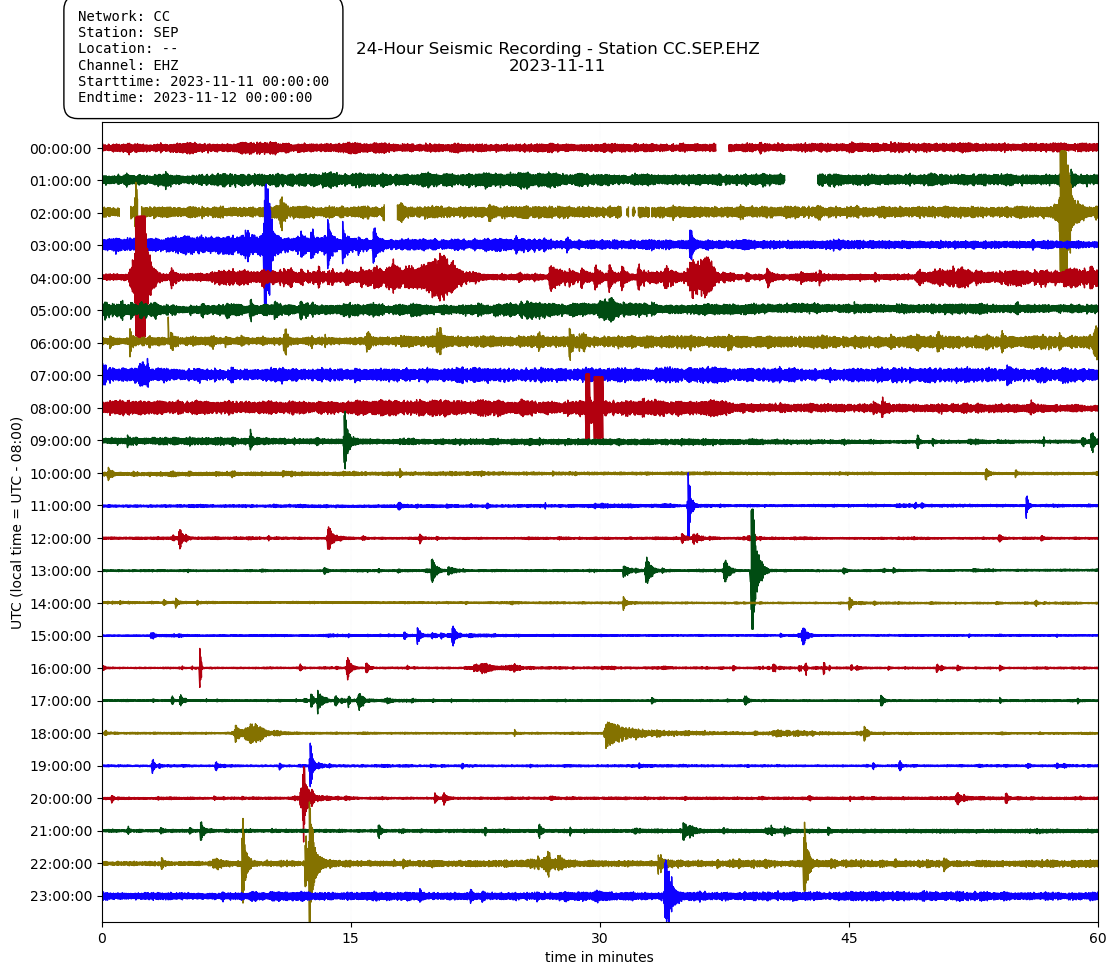

In [27]:
sep01_fig = plot_waveforms(st_01, sep01_metadata)

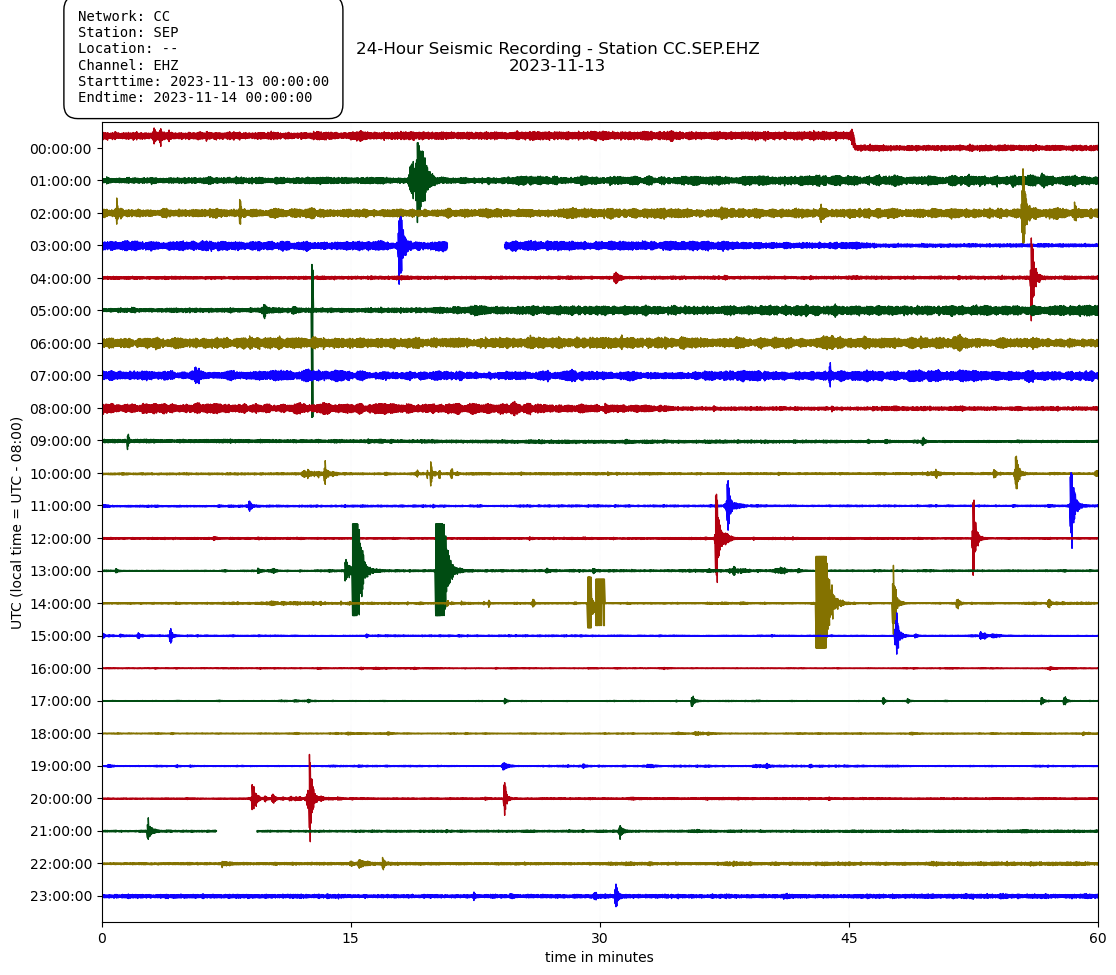

In [28]:
sep02_fig = plot_waveforms(st_02, sep02_metadata)

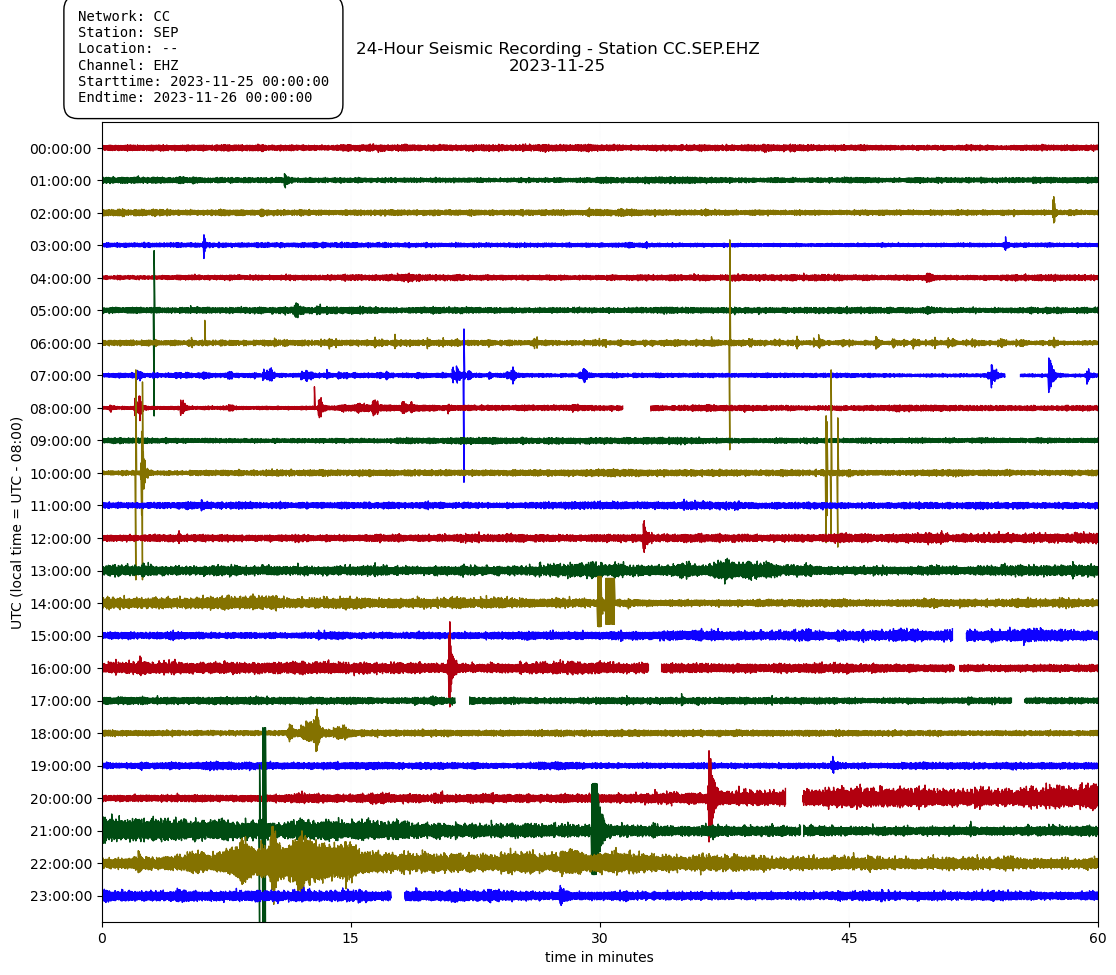

In [29]:
sep03_fig = plot_waveforms(st_03, sep03_metadata)